#### OBJETIVO: Analisis de las estaciones de monitoreo de PM2.5 en los centros urbanos seleccionados. Se hacen distintos plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import locale
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


In [ ]:
### Generar un dataframe con el numero de datos entrnamiento-testeo
datos = pd.DataFrame({
    "Sitio": np.repeat(["SP", "ST", "BA", "MD", "MX"], 2),
    "Tipo": np.tile(["Entrenamiento", "Testeo"], 5),
    "Observaciones": [8867, 3799, 15800, 6768, 2421, 1035, 4695, 2009, 16077, 6887]
})

print(datos)

  Sitio           Tipo  Observaciones
0    SP  Entrenamiento           8867
1    SP         Testeo           3799
2    ST  Entrenamiento          15800
3    ST         Testeo           6768
4    BA  Entrenamiento           2421
5    BA         Testeo           1035
6    MD  Entrenamiento           4695
7    MD         Testeo           2009
8    MX  Entrenamiento          16077
9    MX         Testeo           6887


In [10]:
# Se ordena el dataset segun el numero de datos (entrenamiento y testeo) para hacer el plot
orden_sitios = (
    datos
    .groupby("Sitio", as_index=False)["Observaciones"]
    .sum()
    .sort_values("Observaciones")
    ["Sitio"]
    .tolist()
)

print(orden_sitios)



['BA', 'MD', 'SP', 'ST', 'MX']


C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_15880\2093315385.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Sitio", as_index=False)["Observaciones"]


In [ ]:
# Poner en formato de categorical para poder ordenar los datos

datos["Sitio"] = pd.Categorical(
    datos["Sitio"],
    categories=orden_sitios,
    ordered=True
)
print(datos)

  Sitio           Tipo  Observaciones
0    SP  Entrenamiento           8867
1    SP         Testeo           3799
2    ST  Entrenamiento          15800
3    ST         Testeo           6768
4    BA  Entrenamiento           2421
5    BA         Testeo           1035
6    MD  Entrenamiento           4695
7    MD         Testeo           2009
8    MX  Entrenamiento          16077
9    MX         Testeo           6887


In [ ]:
# Agrupar los dtos por ciudades
datos_prop = datos.copy()

datos_prop["prop"] = (
    datos_prop["Observaciones"]
    / datos_prop.groupby("Sitio")["Observaciones"].transform("sum")
)
tabla = datos_prop.pivot(
    index="Sitio",
    columns="Tipo",
    values="prop"
)

tabla_obs = datos_prop.pivot(
    index="Sitio",
    columns="Tipo",
    values="Observaciones"
)

#Poner en formato de porcentaje
tabla_pct = tabla * 100


C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_15880\2656962190.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  / datos_prop.groupby("Sitio")["Observaciones"].transform("sum")


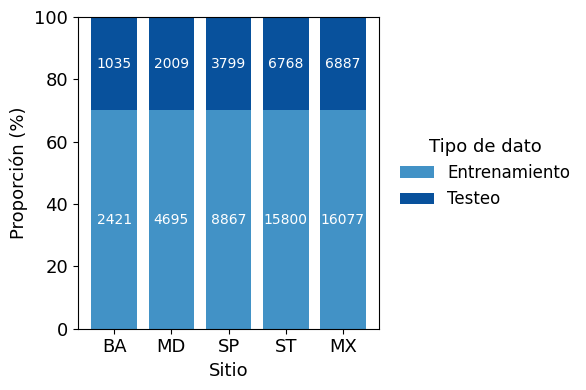

In [ ]:
# Figuara para mostrar cantidad de datos por entrenamiento/testeo
fig, ax = plt.subplots(figsize=(6, 4))

bottom = np.zeros(len(tabla_pct))

colors = {
    "Entrenamiento": "#4292c6",
    "Testeo": "#08519c"
}

for tipo in tabla_pct.columns:
    ax.bar(
        tabla_pct.index,
        tabla_pct[tipo],
        bottom=bottom,
        label=tipo,
        color=colors[tipo]
    )

    # Texto centrado
    for i, sitio in enumerate(tabla_pct.index):
        valor = tabla_pct[tipo].iloc[i]
        obs = tabla_obs[tipo].iloc[i]
        if not np.isnan(valor):
            ax.text(
                i,
                bottom[i] + valor / 2,
                f"{int(obs)}",
                ha="center",
                va="center",
                color="white",
                fontsize=10
            )

    bottom += tabla_pct[tipo].values
ax.set_xlabel("Sitio", fontsize=13)
ax.set_ylabel("Proporción (%)", fontsize=13)

ax.set_ylim(0, 100)

ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)

ax.legend(
    title="Tipo de dato",
    fontsize=12,
    title_fontsize=13,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)


plt.tight_layout()
plt.show()



#### Analisis por centro urbano

In [114]:
# Se lee el archivo generado con todas las variables
estacion = "SP"
ruta_estaciones = (
    f"D:/Josefina/Proyectos/ProyectoChile/"
    f"{estacion}/proceed/06_estaciones/"
    f"{estacion}_estaciones.csv"
)
data  = pd.read_csv(ruta_estaciones)

#Poner en formato fecha
data['date'] = pd.to_datetime(
    data['date'],
    format="%d/%m/%Y",
    errors="coerce"
)

print(data)

       Unnamed: 0       date  ID                    estacion       mean  min  \
0            1333 2015-01-01   3  Ciudad Universitaria - USP  13.500000    0   
1            9693 2015-01-01   7                  Ibirapuera  16.550000    0   
2           16135 2015-01-01  11     Marg.Tiete-Pte Remedios  23.791667    0   
3           27868 2015-01-01  17                   Pinheiros  16.166667    0   
4            2437 2015-01-02   3  Ciudad Universitaria - USP   3.777778    0   
...           ...        ...  ..                         ...        ...  ...   
35134        5971 2024-12-31  12                        Maua  11.000000    0   
35135        6963 2024-12-31  24                      Osasco  12.083333    0   
35136        7327 2024-12-31  22           Parque D.Pedro II  14.208333    0   
35137        8334 2024-12-31  16             Pico do Jaragua   9.333333    0   
35138       10920 2024-12-31  18                     Santana   9.875000    0   

       max         sd  
0       50  14.

In [115]:
# Descartamos aquellas filas donde no hay datos de PM
data.dropna(subset=['mean'], inplace=True)

# Corroboramos si hay datos igual/distinto/mayor/menor  a 0
data = data[data["mean"] != 0]
data = data[data["mean"] > 0]


# Nos quedamos con la info entre 2015-2024
data = data[(data['date'].dt.year >= 2015) & (data['date'].dt.year < 2025)]

#Corroboranos
data['date'].dt.year.unique()



array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      dtype=int32)

In [116]:
#Nombre de las variables
data.columns
# Resumen de las variabels
print("Media", np.mean(data['mean']))
print("SD", np.std(data['mean']))

Media 16.437405274761254
SD 10.334185600112987


In [117]:
# Estadisticas basicas por estacion de monitoreo

resumen_por_estacion = (
    data
    .groupby("estacion", as_index=False)
    .agg(
        cantidad=("mean", "count"),
        promedio=("mean", "mean"),
        minimo=("mean", "min"),
        maximo=("mean", "max"),
        sd=("mean", "std")
    )
)

print(resumen_por_estacion)


                      estacion  cantidad   promedio    minimo      maximo  \
0                  Carapicuiba       365  18.888192  2.791667   76.875000   
1   Ciudad Universitaria - USP      3422  14.331265  1.000000   68.857143   
2         Guarulhos - Pimentas      3146  17.602875  2.166667   99.541667   
3    Guarulhos-Palco Municipal      2732  16.235248  1.933333   78.125000   
4                   Ibirapuera      3204  14.743610  1.583333   63.750000   
5                   Interlagos       320  15.668852  0.739130   68.304348   
6               Itaim Paulista      2892  17.047884  1.000000   85.041667   
7      Marg.Tiete-Pte Remedios      3583  19.570083  1.555556   95.708333   
8                         Maua      1826  14.672721  1.000000   76.083333   
9                       Osasco      2563  20.368470  1.000000  104.250000   
10           Parque D.Pedro II      2803  16.802371  1.500000   85.500000   
11             Pico do Jaragua      2800  12.982061  0.833333   89.739130   

In [52]:
#Cual es la estacion con los valores promedio min
estacion_min = resumen_por_estacion[
    resumen_por_estacion["promedio"] == resumen_por_estacion["promedio"].min()
]

print(estacion_min)
print("----------------------------------------------------------------------------")
#Cual es la estacion con los valores promedio max
estacion_max = resumen_por_estacion[
    resumen_por_estacion["promedio"] == resumen_por_estacion["promedio"].max()
]
print(estacion_max)

print("----------------------------------------------------------------------------")
#Cual es la estacion con los valores  max
estacion_maxTot = resumen_por_estacion[
    resumen_por_estacion["maximo"] == resumen_por_estacion["maximo"].max()
]
print(estacion_maxTot)


          estacion  cantidad  promedio  minimo     maximo         sd
15  Tabao da Serra       249  12.36603     1.0  65.619048  10.056467
----------------------------------------------------------------------------
  estacion  cantidad  promedio  minimo  maximo         sd
9   Osasco      2563  20.36847     1.0  104.25  12.133076
----------------------------------------------------------------------------
  estacion  cantidad  promedio  minimo  maximo         sd
9   Osasco      2563  20.36847     1.0  104.25  12.133076


In [60]:
#     Estadisticas basicas por estacion por mes
# Ver
try:
    locale.setlocale(locale.LC_TIME, "es_ES")
except:
    pass

resumen_por_mes = (
    data
    .assign(
        mes=data["date"].dt.month_name(locale="es_ES")  # nombre del mes
    )
    .groupby("mes", as_index=False)
    .agg(
        minimo=("mean", lambda x: round(x.min(skipna=True), 2)),
        maximo=("mean", lambda x: round(x.max(skipna=True), 2)),
        promedio=("mean", lambda x: round(x.mean(skipna=True), 2)),
        sd=("mean", lambda x: round(x.std(skipna=True), 2)),
    )
)

# Orden correcto de meses
orden_meses = [
    "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
    "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
]

resumen_por_mes["mes"] = pd.Categorical(
    resumen_por_mes["mes"],
    categories=orden_meses,
    ordered=True
)

resumen_por_mes = resumen_por_mes.sort_values("mes")

print(resumen_por_mes)
print(data["date"].dtype)


           mes  minimo  maximo  promedio     sd
3        Enero    1.00   71.80     11.77   5.70
4      Febrero    1.33   55.62     11.91   5.31
7        Marzo    0.74   41.92     12.94   5.56
0        Abril    0.91   59.62     14.58   7.48
8         Mayo    1.67   67.92     17.66   9.15
6        Junio    1.00   92.83     20.55  11.11
5        Julio    1.86   99.54     23.59  12.70
1       Agosto    1.62  104.25     21.03  13.06
11  Septiembre    0.70   95.71     23.17  14.91
10     Octubre    1.14   58.00     14.40   7.37
9    Noviembre    0.83   41.33     12.14   5.50
2    Diciembre    1.07   49.89     12.05   5.50
datetime64[ns]


In [61]:
# Obtener los 3 valores máximos únicos
top3_vals_max = (
    resumen_por_mes["maximo"]
    .dropna()
    .unique()
)

top3_vals_max = sorted(top3_vals_max, reverse=True)[:3]

# Filtrar filas que tienen esos valores
estacion_picos_max = resumen_por_mes[
    resumen_por_mes["maximo"].isin(top3_vals_max)
]

print(estacion_picos_max)


           mes  minimo  maximo  promedio     sd
5        Julio    1.86   99.54     23.59  12.70
1       Agosto    1.62  104.25     21.03  13.06
11  Septiembre    0.70   95.71     23.17  14.91


In [62]:
# Obtener los 3 valores máximos únicos
top3_vals_promedioMax = (
    resumen_por_mes["promedio"]
    .dropna()
    .unique()
)

top3_vals_promedioMax = sorted(top3_vals_promedioMax, reverse=True)[:3]

# Filtrar filas que tienen esos valores
estacion_picos_maxProm = resumen_por_mes[
    resumen_por_mes["promedio"].isin(top3_vals_promedioMax)
]

print(estacion_picos_maxProm)


           mes  minimo  maximo  promedio     sd
5        Julio    1.86   99.54     23.59  12.70
1       Agosto    1.62  104.25     21.03  13.06
11  Septiembre    0.70   95.71     23.17  14.91


In [74]:
#       Serie temporal diaria por estacion para todo 
media_por_estacion = (
    data
    .groupby("estacion", as_index=False)
    .agg(media_estacion=("mean", "mean"))
)

media_por_estacion = media_por_estacion.sort_values("media_estacion")
# Unir la media al dataframe original
data_plot = data.merge(
    media_por_estacion,
    on="estacion",
    how="left"
)



In [118]:
estacion ="SP"
ruta_nombres = (
    f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/dataset/estaciones/"
    f"sitios_{estacion}.csv"
)

nombre_estaciones = pd.read_csv(
    ruta_nombres,
    encoding="utf-8",
    encoding_errors="ignore"
)
# nombre_estaciones
#unir con el anterior data set
data_plot = data_plot.merge(
    nombre_estaciones,
    on="estacion",
    how="left"
)




In [119]:
# Estadísticas por estacion para las etiquetas del plot
stats_por_estacion = (
    data_plot
    .groupby("estacion", as_index=False)
    .agg(
        media=("mean", "mean"),
        maximo=("mean", "max"),
        sd=("mean", "std")
    )
)

stats_por_estacion[["media", "maximo", "sd"]] = (
    stats_por_estacion[["media", "maximo", "sd"]].round(2)
)


In [121]:
#Etiquetas para el plot
stats_por_estacion["label"] = (
    "Media: " + stats_por_estacion["media"].astype(str) +
    "\nSD: " + stats_por_estacion["sd"].astype(str) +
    "\nMax: " + stats_por_estacion["maximo"].astype(str)
)

stats_por_estacion["x"] = pd.to_datetime("2015-01-01")
stats_por_estacion["y"] = 120
# Lineas
lineas_extra = pd.DataFrame({
    "estacion": data_plot["estacion"].unique(),
    "total_mean": 18.56 ###Ojo media por centro urbano
})


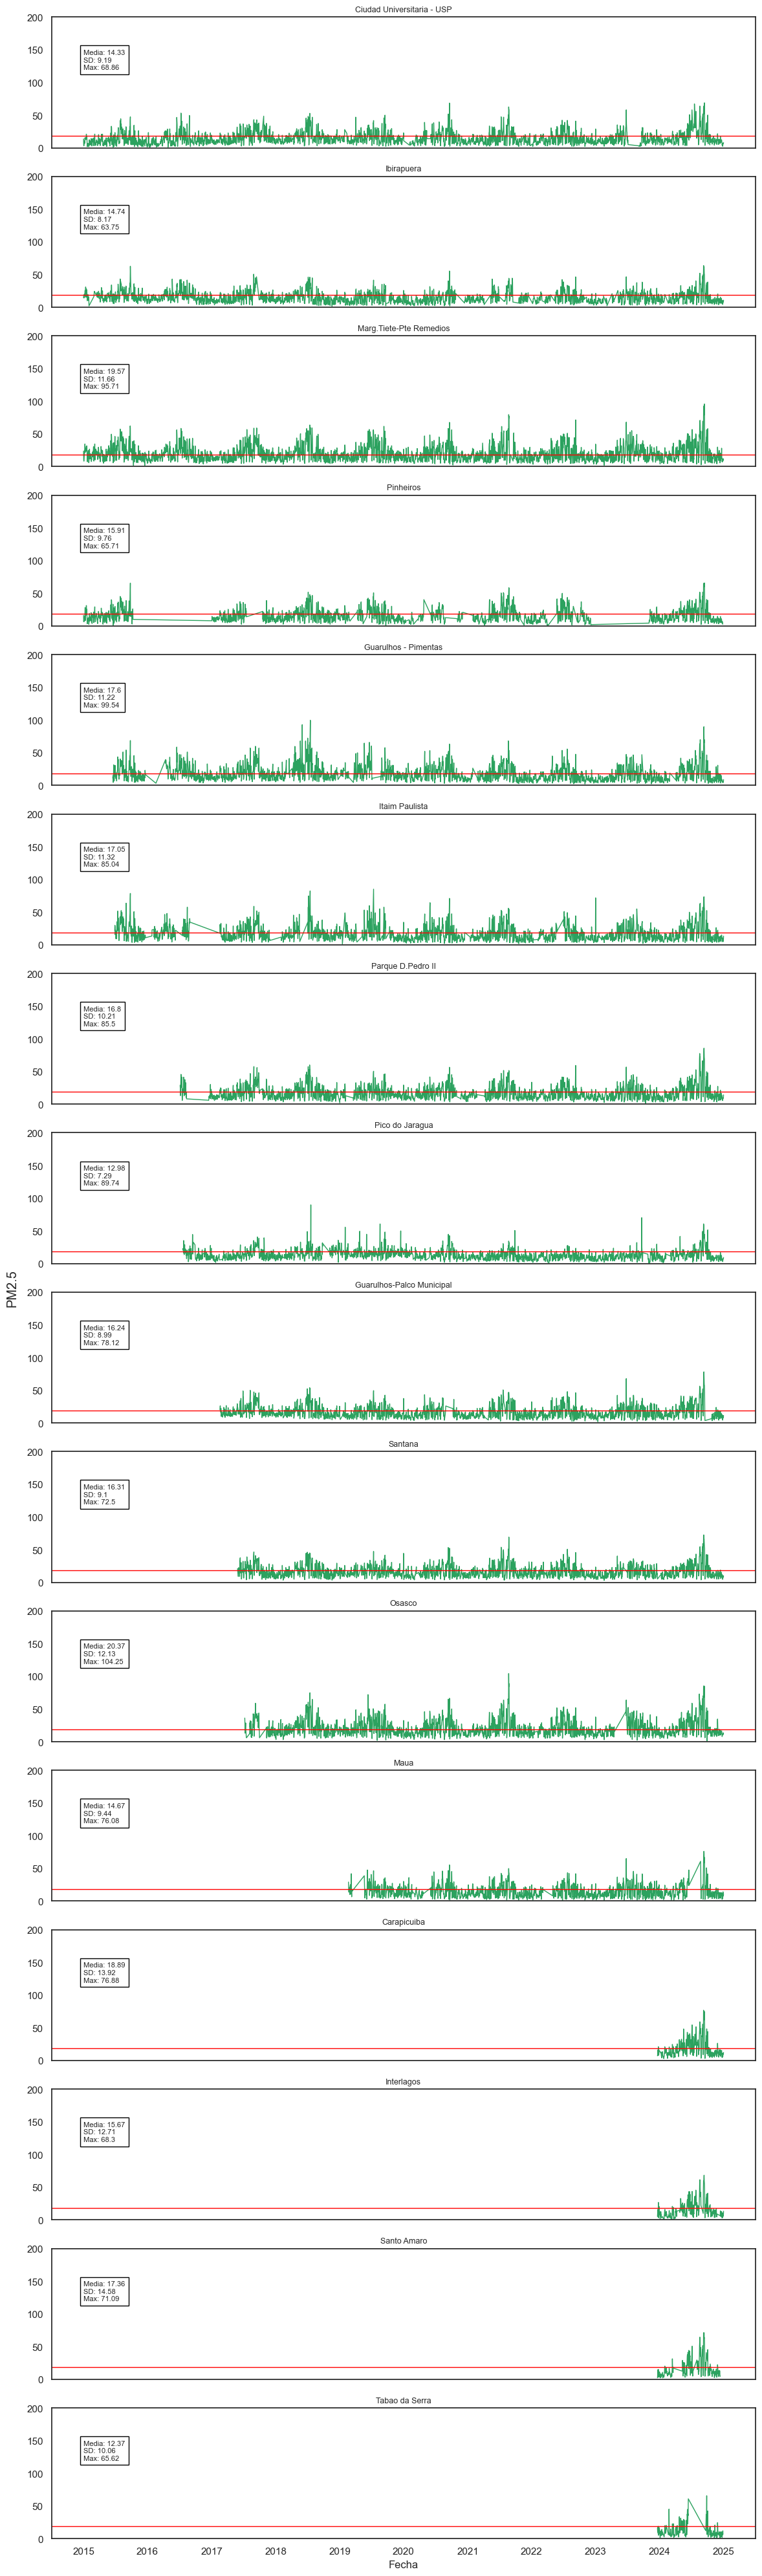

In [122]:
# Plot de todas las estaciones
estaciones = data_plot["estacion"].unique()
n = len(estaciones)

fig, axes = plt.subplots(
    nrows=n,
    ncols=1,
    figsize=(12, 2.5 * n),
    sharex=True,
    sharey=True
)

if n == 1:
    axes = [axes]

for ax, est in zip(axes, estaciones):
    df_est = data_plot[data_plot["estacion"] == est]
    stats = stats_por_estacion[stats_por_estacion["estacion"] == est].iloc[0]

    # Serie temporal
    ax.plot(df_est["date"], df_est["mean"],
            color="#2ca25f", linewidth=1)

    # Línea horizontal
    #  Ojo que corresponde a la media por centro urbano
    ax.axhline(18.56, color="red", linewidth=1)

    # Etiqueta estadística
    ax.text(
        stats["x"], stats["y"],
        stats["label"],
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="black")
    )

    ax.set_title(est, fontsize=9)
    ax.set_ylim(0, 200)

# Ejes
axes[-1].set_xlabel("Fecha")
fig.supylabel("PM2.5")

plt.tight_layout()
plt.show()


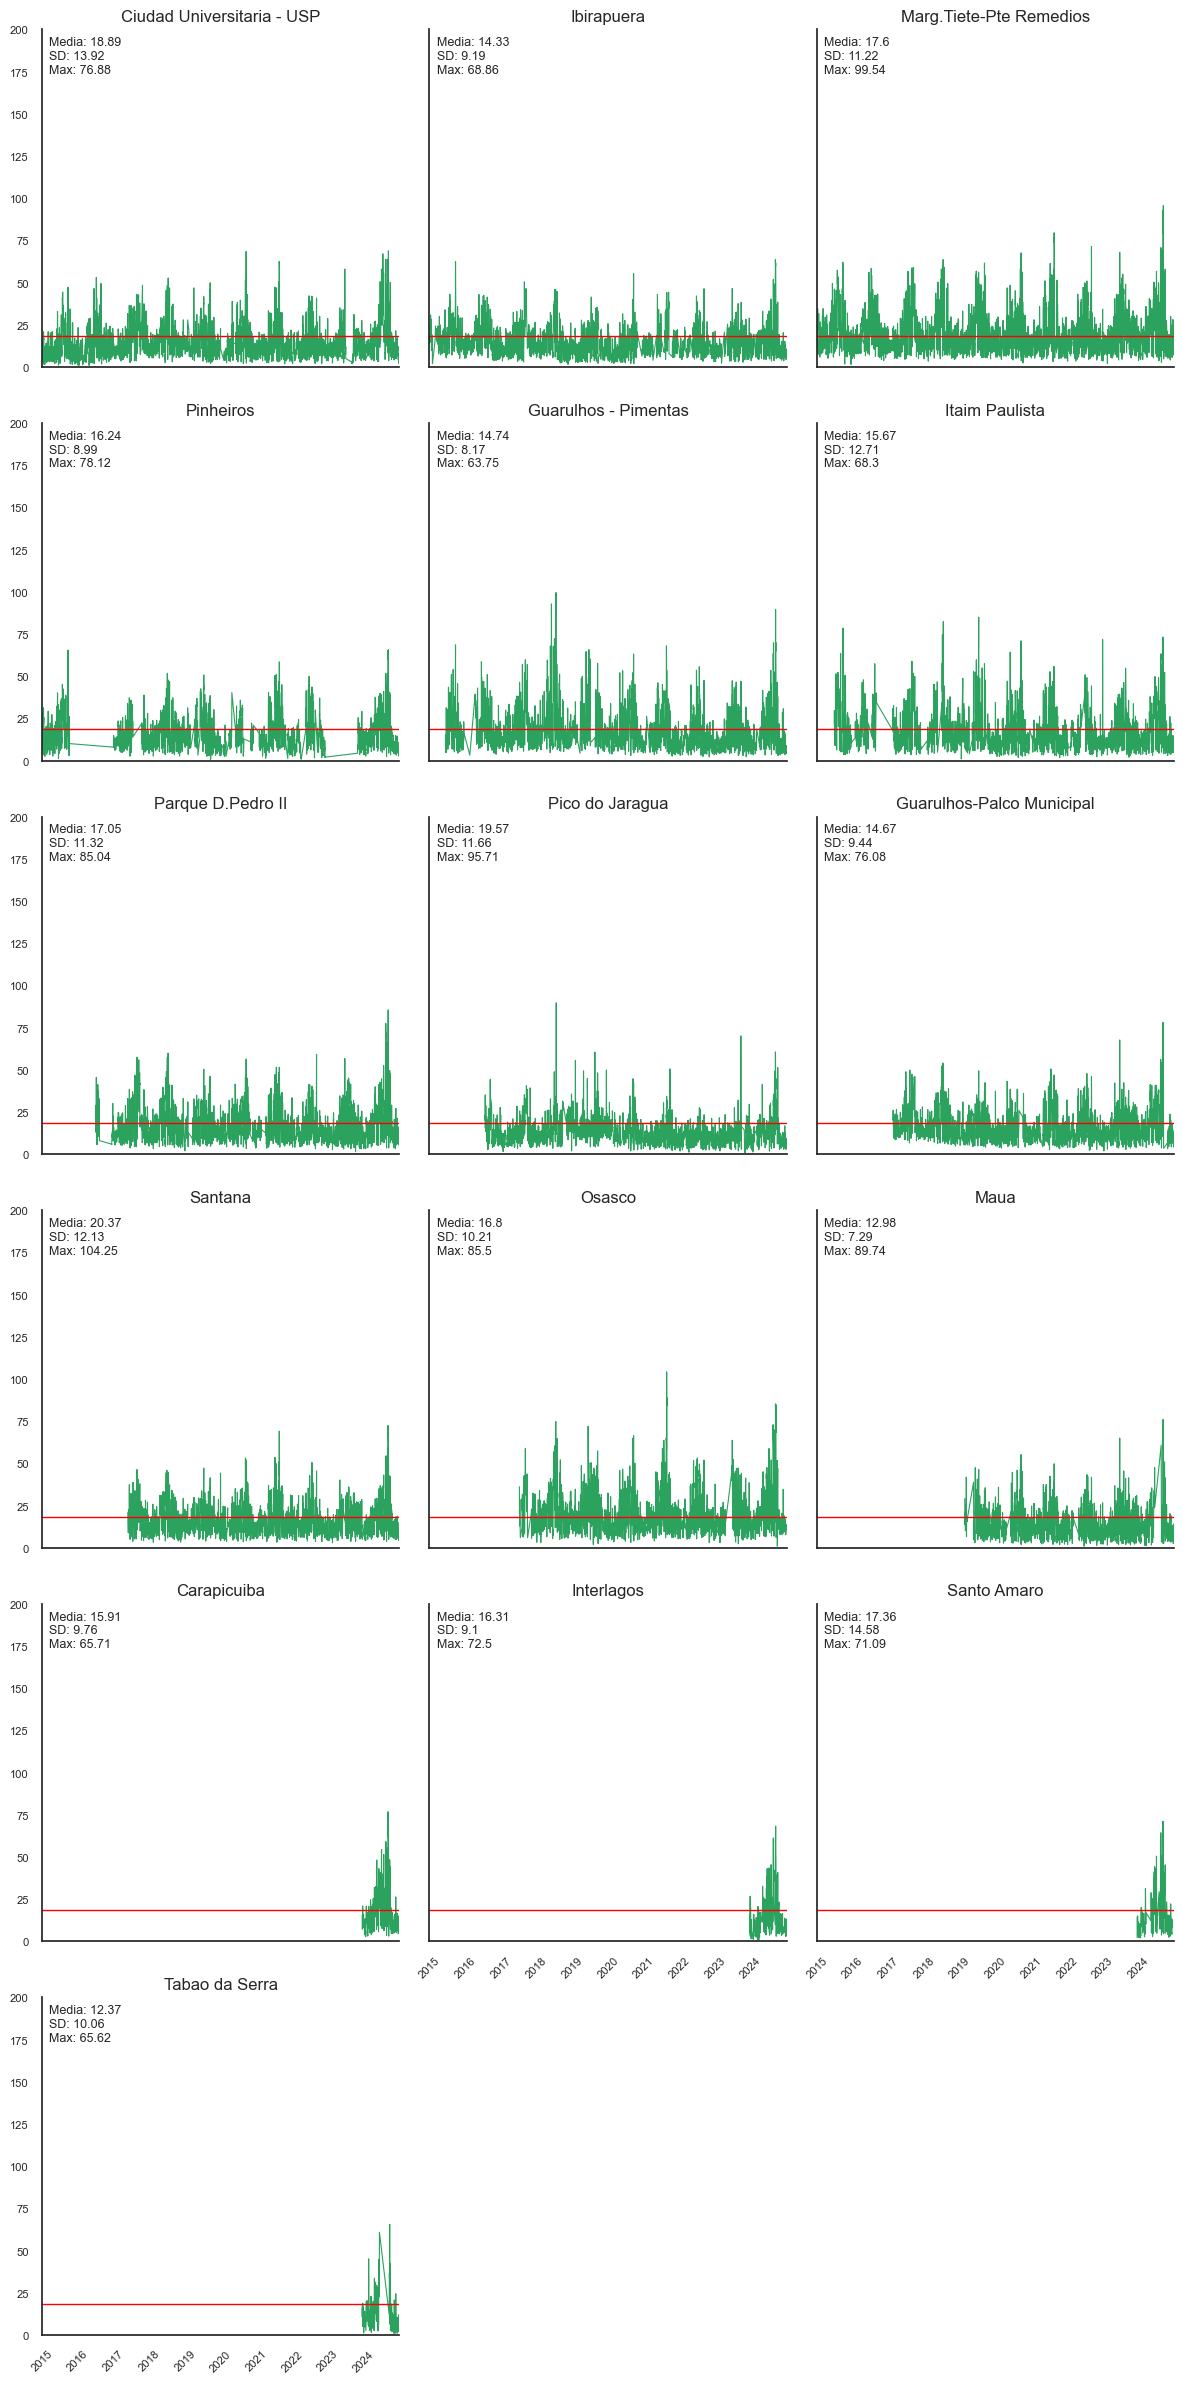

In [ ]:
#Plots similares con seaborn
sns.set_theme(style="white")
g = sns.FacetGrid(
    data_plot,
    col="estacion",
    col_wrap=3,
    height=4,
    sharex=True,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="date",
    y="mean",
    color="#2ca25f",
    linewidth=0.8
)
g.set_titles("{col_name}")

for ax in g.axes.flatten():
    ax.axhline(18.56, color="red", linewidth=1)

stats = (
    data_plot
    .groupby("estacion")["mean"]
    .agg(media="mean", sd="std", maximo="max")
    .round(2)
    .reset_index()
)

for ax, est in zip(g.axes.flatten(), stats["estacion"]):

    s = stats[stats["estacion"] == est].iloc[0]

    label = (
        f"Media: {s.media}\n"
        f"SD: {s.sd}\n"
        f"Max: {s.maximo}"
    )

    ax.text(
        0.02, 0.98, label,          # 👈 posición relativa
        transform=ax.transAxes,     # 👈 CLAVE
        ha="left",
        va="top",
        fontsize=9,
        bbox=dict(facecolor="white", alpha=0.9, edgecolor="none")
    )


g.set(
    xlim=(pd.to_datetime("2015-01-01"),
          pd.to_datetime("2024-12-31")),
    ylim=(0, 200)
)

for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.tick_params(axis="y", labelsize=8)


sns.despine()
g.set_axis_labels("", "")
g.fig.tight_layout()
plt.show()


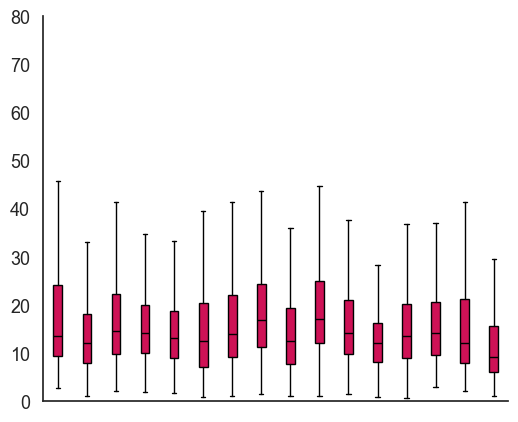

In [ ]:
#             boxplot por estacion
# La idea no es mostrar el nombre de la estacion queremos saber en general si hay diferencias o no
#Plot de tesis
# Asegurar que 'estacion' sea categórica y ordenada
data["estacion"] = data["estacion"].astype("category")

# Crear lista de datos por estación
estaciones = data["estacion"].cat.categories
valores = [data.loc[data["estacion"] == est, "mean"].dropna()
           for est in estaciones]

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(
    valores,
    widths=0.3,
    patch_artist=True,
    showfliers=False,            # equivale a outlier.shape = NA
    boxprops=dict(facecolor="#ce1256", edgecolor="black"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black")
)

# Ejes
ax.set_ylim(0, 80)
ax.set_xlabel("")
ax.set_ylabel("")

# Quitar etiquetas del eje X
ax.set_xticks(range(1, len(estaciones) + 1))
ax.set_xticklabels([""] * len(estaciones))
ax.tick_params(axis="x", length=0)

# Tamaño del texto eje Y
ax.tick_params(axis="y", labelsize=13)

# Estilo clásico
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()


In [123]:
#             Promedios por año

# Asegurar que date sea datetime
data["date"] = pd.to_datetime(data["date"])

# Crear columna year
data["year"] = data["date"].dt.year

# Promedios anuales
promedio_anuales = (
    data
    .groupby("year")
    .agg(
        avg_pm25=("mean", "mean"),
        min=("mean", "min"),
        max=("mean", "max")
    )
    .reset_index()
)

print(promedio_anuales)


   year   avg_pm25       min         max
0  2015  17.537362  1.208333   78.541667
1  2016  16.607865  1.000000   58.583333
2  2017  16.945346  1.571429   59.750000
3  2018  17.588122  1.583333   99.541667
4  2019  17.107136  0.695652   85.041667
5  2020  15.551702  1.916667   70.958333
6  2021  15.932034  1.250000  104.250000
7  2022  14.604941  0.909091   71.416667
8  2023  14.966104  0.833333   71.800000
9  2024  17.867308  0.739130   95.708333


In [ ]:
#            % de cambio 2015-2024 total
######################################################
### Las concentraciones diminuyeron/aumentaron entre 2015-2024
prom_2015 = promedio_anuales[promedio_anuales["year"] == 2015]
prom_2024 = promedio_anuales[promedio_anuales["year"] == 2024]

#Corroborar el filtro
print(prom_2015["year"].unique())
print(prom_2024["year"].unique())

# Porcentaje de cambio entre los años
valor = float(
    round(
        ((prom_2015["avg_pm25"].values[0] - prom_2024["avg_pm25"].values[0])
         / prom_2015["avg_pm25"].values[0]) * 100,
        2
    )
)

print(valor)


[2015]
[2024]
-1.88


In [ ]:
#            % de cambio 2015-2024 por estaciones
# Primero calcular promedio anual por estacion
promedio_anuales = (
    data
    .groupby(["estacion", "year"], as_index=False)
    .agg(avg_pm25=("mean", "mean"))
)

# Nos queadmos con los datos de las estaciones solo para los años 2015  y 2024

prom_2015_estaciones = promedio_anuales[promedio_anuales["year"] == 2015]
prom_2024_estaciones = promedio_anuales[promedio_anuales["year"] == 2024]

print("Prom 2015", prom_2015_estaciones)
print("-------------------------------------------------------------")
print("Prom 2024",prom_2024_estaciones)

# Para SP y para todos los sitios fijarse que las estaciones no tienen siempre comienzan en 2015 hasta 2024

Prom 2015                       estacion  year   avg_pm25
2   Ciudad Universitaria - USP  2015  11.640321
12        Guarulhos - Pimentas  2015  19.147585
30                  Ibirapuera  2015  17.270405
42              Itaim Paulista  2015  21.813518
52     Marg.Tiete-Pte Remedios  2015  21.183504
94                   Pinheiros  2015  17.167982
-------------------------------------------------------------
Prom 2024                        estacion  year   avg_pm25
1                   Carapicuiba  2024  19.097179
11   Ciudad Universitaria - USP  2024  17.722885
21         Guarulhos - Pimentas  2024  18.113711
29    Guarulhos-Palco Municipal  2024  18.520866
39                   Ibirapuera  2024  15.878766
41                   Interlagos  2024  15.865778
51               Itaim Paulista  2024  17.965766
61      Marg.Tiete-Pte Remedios  2024  22.539567
67                         Maua  2024  15.827542
75                       Osasco  2024  22.122348
84            Parque D.Pedro II  2024  19.8

In [ ]:
# Se renombran las columnas y se gnera un nuevo dataset para unir todo
d2015 = prom_2015_estaciones[["estacion", "avg_pm25"]].rename(
    columns={"avg_pm25": "avg_pm25_2015"}
)

d2024 = prom_2024_estaciones[["estacion", "avg_pm25"]].rename(
    columns={"avg_pm25": "avg_pm25_2024"}
)

#Unir solo estaciones que esten disponibles en ambos dataset
cambios_por_estacion = d2015.merge(
    d2024,
    on="estacion",
    how="left"
)


# Calcular el % de cambio por estaicon
cambios_por_estacion["porcentaje_cambio"] = (
    (cambios_por_estacion["avg_pm25_2024"] -
     cambios_por_estacion["avg_pm25_2015"])
    / cambios_por_estacion["avg_pm25_2015"]
    * 100
).round(2)

#Visualizacion
print(cambios_por_estacion)

#Comentario: # Si es positivo significa que aumentaron las concentraciones, si el valor es negativo es 
# porque disminuyeron los valores entre 2015 y 2024



                     estacion  avg_pm25_2015  avg_pm25_2024  porcentaje_cambio
0  Ciudad Universitaria - USP      11.640321      17.722885              52.25
1        Guarulhos - Pimentas      19.147585      18.113711              -5.40
2                  Ibirapuera      17.270405      15.878766              -8.06
3              Itaim Paulista      21.813518      17.965766             -17.64
4     Marg.Tiete-Pte Remedios      21.183504      22.539567               6.40
5                   Pinheiros      17.167982      17.120730              -0.28


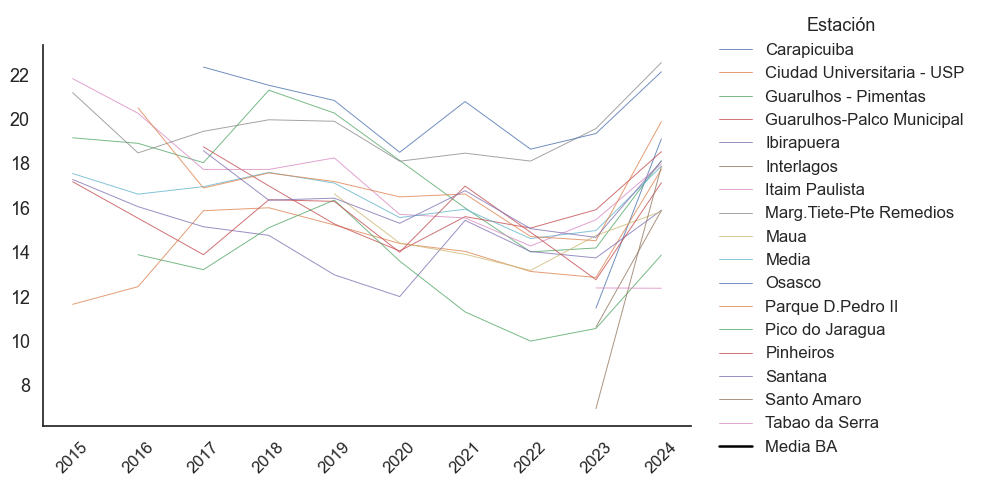

In [ ]:
#       Serie temporal por año por estacion

# Setear la fecha
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year

#Promedio anual por estacion (se repite)
promedios_estacion = (
    data
    .groupby(["estacion", "year"], as_index=False)
    .agg(avg_pm25=("mean", "mean"))
)
# Promedio anual general (todas las estaciones)
promedio_general = (
    data
    .groupby("year", as_index=False)
    .agg(avg_pm25=("mean", "mean"))
)

promedio_general["estacion"] = "Media"

# Unir ambos conjuntos (equivalente a bind_rows)
serie_completa = pd.concat(
    [promedios_estacion, promedio_general],
    ignore_index=True
)
##############################################################################
#PLOT media anual para cada estacion
fig, ax = plt.subplots(figsize=(10, 5))
for estacion, df_est in serie_completa.groupby("estacion"):
    if estacion != "Media BA":
        ax.plot(
            df_est["year"],
            df_est["avg_pm25"],
            linewidth=0.7,
            alpha=0.8,
            label=estacion
        )
df_media = serie_completa[serie_completa["estacion"] == "Media BA"]

ax.plot(
    df_media["year"],
    df_media["avg_pm25"],
    color="black",
    linewidth=1.8,
    label="Media BA"
)
ax.set_xticks(range(2015, 2025))
ax.set_xlabel("")
ax.set_ylabel("")

ax.tick_params(axis="x", rotation=45, labelsize=12)
ax.tick_params(axis="y", labelsize=13)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.legend(
    title="Estación",
    fontsize=12,
    title_fontsize=13,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)
plt.tight_layout()
plt.show()


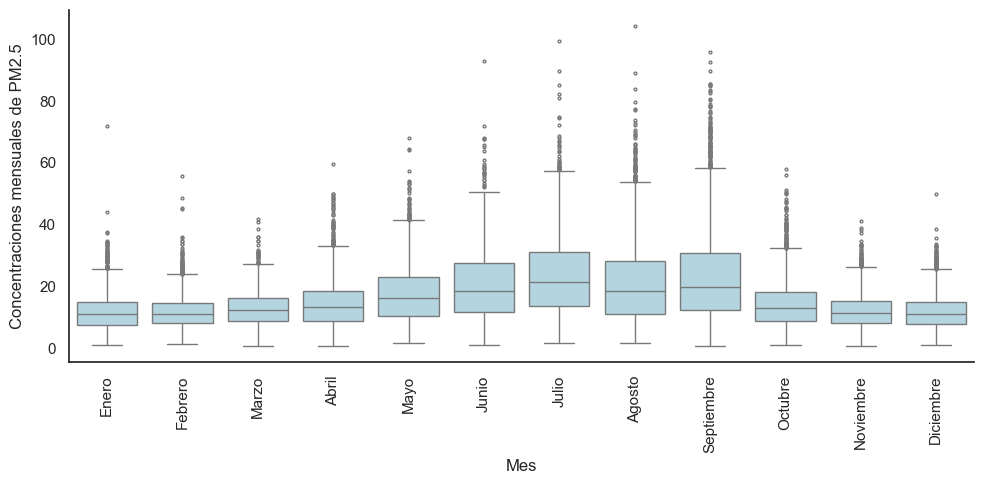

In [144]:
#Otro plot
# Boxplor con seanborn

# asegurar fecha
data["date"] = pd.to_datetime(data["date"])

# mes como nombre completo
data["mes"] = data["date"].dt.month_name(locale="es_ES")
# print(data["mes"]) #Estan en mayusculas la primera, por eso no funciona
# # ordenar meses
orden_meses = [
    "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
    "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
]
# Cambiar formato del dato
data["mes"] = pd.Categorical(
    data["mes"],
    categories=orden_meses,
    ordered=True
)

###################################################################
#Hacer plot
plt.figure(figsize=(10, 5))

sns.boxplot(
    data=data,
    x="mes",
    y="mean",
    color="lightblue",
    fliersize=2,
    linewidth=1
)

plt.xlabel("Mes")
plt.ylabel("Concentraciones mensuales de PM2.5")

plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()
plt.show()



In [155]:
# Preparacion de datos para la seleccion de variables con el Factor VIF
estacion = "SP"

ruta = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/proceed/merge_tot/{estacion}_merge_comp.csv"
data_com = pd.read_csv(ruta)

# Fecha a datetime
data_com["date"] = pd.to_datetime(data_com["date"])

# Día de la semana (lunes=1 como en R)
data_com["dayWeek"] = data_com["date"].dt.weekday + 1

# Verificar años
data_com["year"] = data_com["date"].dt.year
data_com["year"].unique()

data_com = data_com[data_com["year"] != 2024]

data_com["year"].unique()

#Selección de variables
variables = [
    "AOD_055", "ndvi", "BCSMASS_dia", "DUSMASS_dia", "OCSMASS_dia",
    "t2m_mean", "SO2SMASS_dia", "SO4SMASS_dia", "SSSMASS_dia",
    "blh_mean", "sp_mean", "d2m_mean", "v10_mean", "u10_mean",
    "tp_mean", "DEM", "dayWeek"
]

X = data_com[variables].dropna()

# Agregar constante
X = sm.add_constant(X)

# Calcular FIF
vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

# Quitar la constante y ordenar
vif_df = vif_df[vif_df["variable"] != "const"]

vif_df = vif_df.sort_values("VIF", ascending=False)
#Resultado (da lo mismo que en r??)
print(vif_df)



        variable       VIF
3    BCSMASS_dia  9.784876
6       t2m_mean  9.222693
5    OCSMASS_dia  8.272997
12      d2m_mean  8.055352
2           ndvi  5.402465
16           DEM  5.098387
14      u10_mean  3.469391
13      v10_mean  3.293024
10      blh_mean  2.280824
7   SO2SMASS_dia  2.042308
11       sp_mean  1.930901
8   SO4SMASS_dia  1.631011
9    SSSMASS_dia  1.622498
1        AOD_055  1.612145
15       tp_mean  1.301100
4    DUSMASS_dia  1.265392
17       dayWeek  1.002337


Interpretacion del VIF
- 1	No colinealidad
- 5 – 10	Colinealidad moderada
- >= 10	Colinealidad severa (revisar variable)

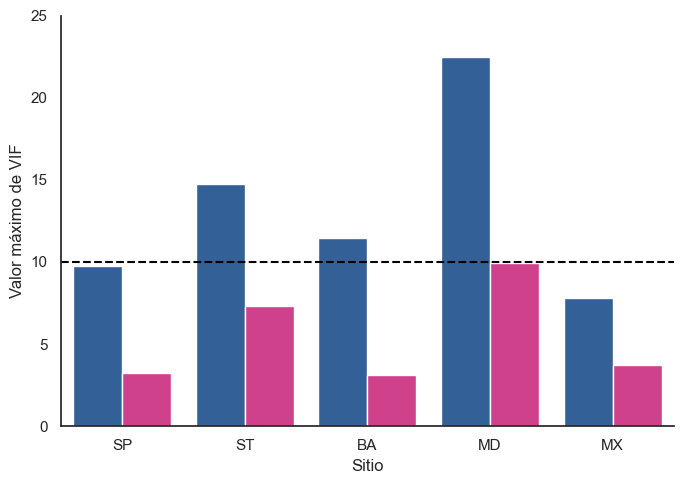

In [156]:
#PLOT de valores maximos de VIF para cada centro urbano

vif_data = pd.DataFrame({
    "Centro": ["SP", "ST", "BA", "MD", "MX"],
    "VIF_Antes": [9.78, 14.74, 11.44, 22.46, 7.83],
    "VIF_Despues": [3.25, 7.34, 3.12, 9.92, 3.70]
})

vif_long = vif_data.melt(
    id_vars="Centro",
    value_vars=["VIF_Antes", "VIF_Despues"],
    var_name="Estado",
    value_name="VIF"
)
vif_long["Centro"] = pd.Categorical(
    vif_long["Centro"],
    categories=["SP", "ST", "BA", "MD", "MX"],
    ordered=True
)

vif_long["Estado"] = vif_long["Estado"].replace({
    "VIF_Antes": "Antes de depuración",
    "VIF_Despues": "Después de depuración"
})

plt.figure(figsize=(7,5))

sns.barplot(
    data=vif_long,
    x="Centro",
    y="VIF",
    hue="Estado",
    dodge=True,
    palette=["#225ea8", "#e7298a"]
)

plt.axhline(10, color="black", linestyle="--")
plt.ylim(0, 25)

plt.xlabel("Sitio")
plt.ylabel("Valor máximo de VIF")

plt.legend().remove()
sns.despine()
plt.tight_layout()
plt.show()
